In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")

In [3]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [4]:
#Delete useless company
target_date = pd.Timestamp('2022-02-02')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]

In [6]:
#Data for simulate
start_date = pd.Timestamp('2022-02-02')
end_date = pd.Timestamp('2022-11-17')


pred_date = pd.Timestamp('2023-02-17')

#Get data for a specific time period
true_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

pred_stock_data = stock_data[(stock_data['Date'] == pred_date)][['Company', 'Close']].rename(columns={'Close': 'true_y'})


In [7]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = true_stock_data[(true_stock_data['Company'] == company) & (true_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        open_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(open_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(open_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': None})

#Calculate the signature
signatures = true_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
true_stock_data = true_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [8]:
#Change 1 col into 6
true_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(true_stock_data['Signature'].tolist(), index=true_stock_data.index)

#Delete old col
true_stock_data = true_stock_data.drop(columns=['Signature'])


In [9]:
true_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
378833,2022-02-02,172.775924,173.893164,171.371967,173.853607,84914300,0.0,0.0,AAPL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378834,2022-02-02,304.059596,309.450818,303.323089,307.820679,36636000,0.0,0.0,MSFT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378835,2022-02-02,151.250000,151.546494,145.522507,148.000000,123200000,0.0,0.0,GOOGL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378836,2022-02-02,155.050507,155.074997,148.863495,150.612503,87330000,0.0,0.0,AMZN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378837,2022-02-02,257.607384,257.837098,245.213383,252.094498,54341900,0.0,0.0,NVDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476614,2022-11-17,26.646071,26.723278,26.414450,26.703976,5050900,0.0,0.0,PPL,-1.287447,-1.175765,-1.287447,0.828760,-1.175765,0.691212
476615,2022-11-17,33.528712,33.661989,33.166959,33.633430,3456200,0.0,0.0,FITB,-9.682701,-8.979942,-9.682701,46.877350,-8.979942,40.319676
476616,2022-11-17,93.225829,94.696297,93.110496,94.071587,1572200,0.0,0.0,IFF,-31.431343,-32.606387,-31.431343,493.964664,-32.606387,531.588232
476617,2022-11-17,23.548800,23.678300,23.230035,23.568724,4074700,0.0,0.0,CCJ,3.825186,2.998388,3.825186,7.316023,2.998388,4.495165


In [14]:
#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = true_stock_data[true_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-02').date()) & (company_data['Date'] <= pd.Timestamp('2022-08-17').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-05-09').date()) & (company_data['Date'] <= pd.Timestamp('2022-11-17').date())]['Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-11-17').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

    
#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
true_result = pred_stock_data.merge(results_df, on='Company')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7487061018027816, tolerance: 0.5591203843618512
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7241101794861606, tolerance: 0.6245182964008469
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7684197569133175, tolerance: 0.6245182964008469
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0765674442108093, tolerance: 0.04382922015386594
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08796146081351708, tolerance: 0.04382922015386594
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08649344387924884, tolerance: 0.04382922015386594
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.954847754666844, tolerance: 1.6409582318323843
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3457031584894139, tolerance: 0.2081859907640476
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35500662403705974, tolerance: 0.2081859907640476
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.46107935496184, tolerance: 1.8148377771997684
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.553784935589647, tolerance: 1.8148377771997684
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.791326629352625, tolerance: 1.8148377771997684
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1470192001270334, tolerance: 0.1450549724890072
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20868590536497322, tolerance: 0.1450549724890072
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.832736631120497, tolerance: 6.723423632432908
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.920905358741038, tolerance: 0.9232184494562873
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.819922182531172, tolerance: 0.6221910408725427
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.740848742976596, tolerance: 0.6221910408725427
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01363653375298668, tolerance: 0.008438494426243864
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01400422538867474, tolerance: 0.008438494426243864
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013968419307857971, tolerance: 0.008438494426243864
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07767133683563543, tolerance: 0.02948020725376121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07835216088244579, tolerance: 0.02948020725376121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07824530021810006, tolerance: 0.02948020725376121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.207661281010587, tolerance: 1.1909525553558789
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2443211598056223, tolerance: 1.1909525553558789
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.257171247721999, tolerance: 1.1909525553558789
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7282201912321398, tolerance: 0.5383002647234828
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.523e-01, tolerance: 3.338e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015290164286216879, tolerance: 0.001490789848981205
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5078097647678987, tolerance: 0.3138242970309045
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.530311394193177, tolerance: 0.3138242970309045
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5341722831781226, tolerance: 0.3138242970309045
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1151363765493443, tolerance: 2.0567872309252677
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.110899622570287, tolerance: 2.0567872309252677
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7855577200589323, tolerance: 1.7108099610859464
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.728590879464718, tolerance: 0.5731116209453849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.332668001222828, tolerance: 0.5731116209453849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.972099878971676, tolerance: 0.5731116209453849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.23020537732373, tolerance: 5.9398894069495976
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.764106648137385, tolerance: 5.9398894069495976
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054732652789653, tolerance: 0.04919721402360102
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.186e-01, tolerance: 9.796e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1987079403813823, tolerance: 0.09776494396851314
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2439593151018471, tolerance: 0.09776494396851314
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2509840184829955, tolerance: 0.9547337385064705
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2543818172998726, tolerance: 0.9547337385064705
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2175744867181493, tolerance: 0.9547337385064705
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7099701687857305, tolerance: 0.6429694703308654
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6800359540493446, tolerance: 0.6429694703308654
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6474717549372144, tolerance: 0.6429694703308654
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2869527795569411, tolerance: 0.2744299394532094
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29781045214144797, tolerance: 0.2744299394532094
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30353481213569466, tolerance: 0.2744299394532094
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048667608342944924, tolerance: 0.0001309927225815124
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008369028304144877, tolerance: 0.0001309927225815124
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026896650874477235, tolerance: 0.0001309927225815124
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6211054177506412, tolerance: 0.43252657703627695
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8582725181940987, tolerance: 0.43252657703627695
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9477790747469044, tolerance: 0.43252657703627695
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1495998543450696, tolerance: 1.3152590578315655
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.979107859182477, tolerance: 1.3152590578315655
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.03901461368514, tolerance: 1.3152590578315655
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.39454357404611, tolerance: 24.122885358770677
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12467034616786066, tolerance: 0.0031393324953142418
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3882956127053383, tolerance: 0.0031393324953142418
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.30245742001716, tolerance: 5.424700098369845
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.6585907134795, tolerance: 5.424700098369845
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.459047059375735, tolerance: 5.424700098369845
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Co

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05452004960989143, tolerance: 0.038948127483044034
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09688565298444018, tolerance: 0.038948127483044034
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10739636187696533, tolerance: 0.038948127483044034
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2243616630430552, tolerance: 0.7045025892894421
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4529845437646145, tolerance: 0.7045025892894421
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4595030982491153, tolerance: 0.7045025892894421
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8361352819156309, tolerance: 0.7029623868351886
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8439683334272559, tolerance: 0.7029623868351886
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8323767565525486, tolerance: 0.7029623868351886
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.418075920031697, tolerance: 5.399256408340295
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.110905586960143, tolerance: 5.399256408340295
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.96143733003555, tolerance: 5.399256408340295
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036276448693769225, tolerance: 0.029545136709283708
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04634644447517644, tolerance: 0.029545136709283708
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.046920368784839184, tolerance: 0.029545136709283708
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

In [15]:
#Calcilate difference
true_result["difference"] = (true_result["true_y"] - true_result["predicted_y"]).abs()
true_result["difference_percentage"] = (true_result["difference"] / true_result["true_y"]) * 100

#Sort by difference
true_result_sorted = true_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(true_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(true_result_sorted.tail(10))

10 lines with lowest difference:
    Company      true_y  predicted_y  difference  difference_percentage
187      BN   35.592812    35.607585    0.014773               0.041506
472     NOK    4.571431     4.517034    0.054397               1.189932
412     TEF    3.928165     3.868950    0.059215               1.507455
464     AEE   85.263908    85.326772    0.062863               0.073728
227    BSBR    5.565691     5.475644    0.090048               1.617906
32      CRM  165.169998   165.265777    0.095779               0.057988
414    RBLX   40.880001    40.742353    0.137648               0.336712
254    ABEV    2.520000     2.686782    0.166782               6.618319
177    ITUB    4.964704     4.779969    0.184735               3.720961
27       KO   58.745338    59.027244    0.281906               0.479878

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
208     TDG   717.586731   550.653392  166.933339              23.

In [16]:
#Calculate overall R² score
overall_r2_score = r2_score(true_result['true_y'], true_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.959103959430828


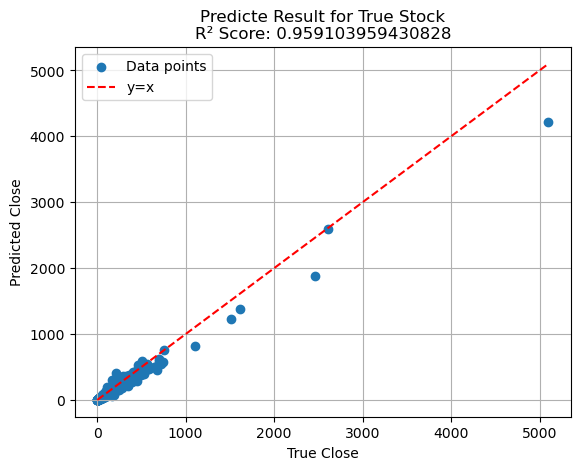

In [17]:
#Plot
plt.scatter(true_result['true_y'], true_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for True Stock\nR² Score: {overall_r2_score}')
plt.plot([true_result['true_y'].min(), true_result['true_y'].max()], [true_result['true_y'].min(), true_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()

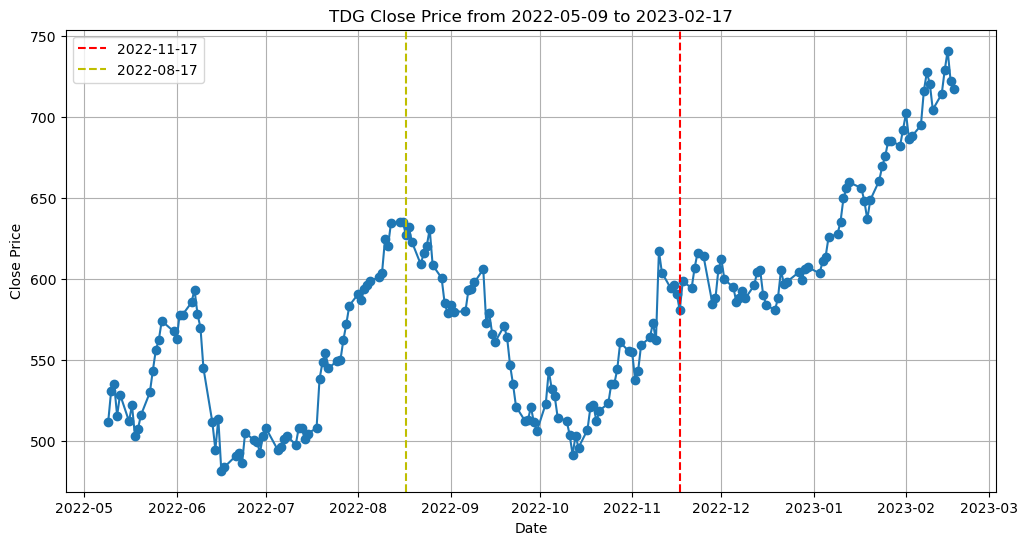

In [22]:
companyplot = 'TDG'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

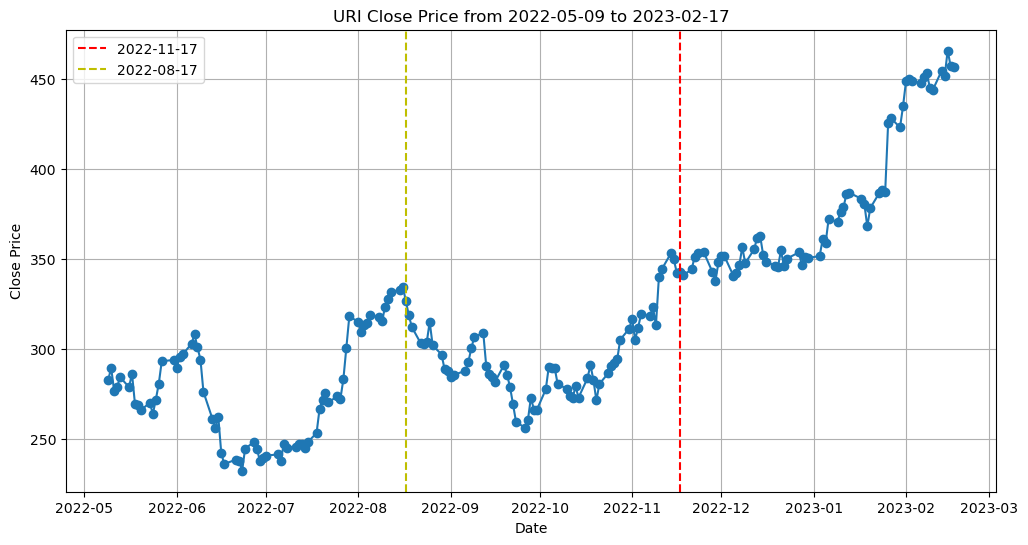

In [23]:
companyplot = 'URI'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

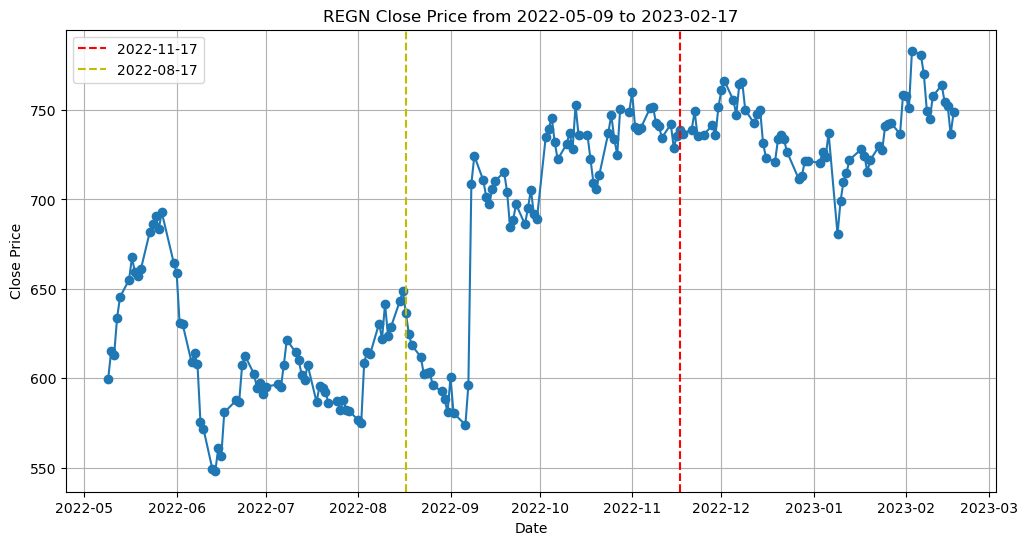

In [24]:
companyplot = 'REGN'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

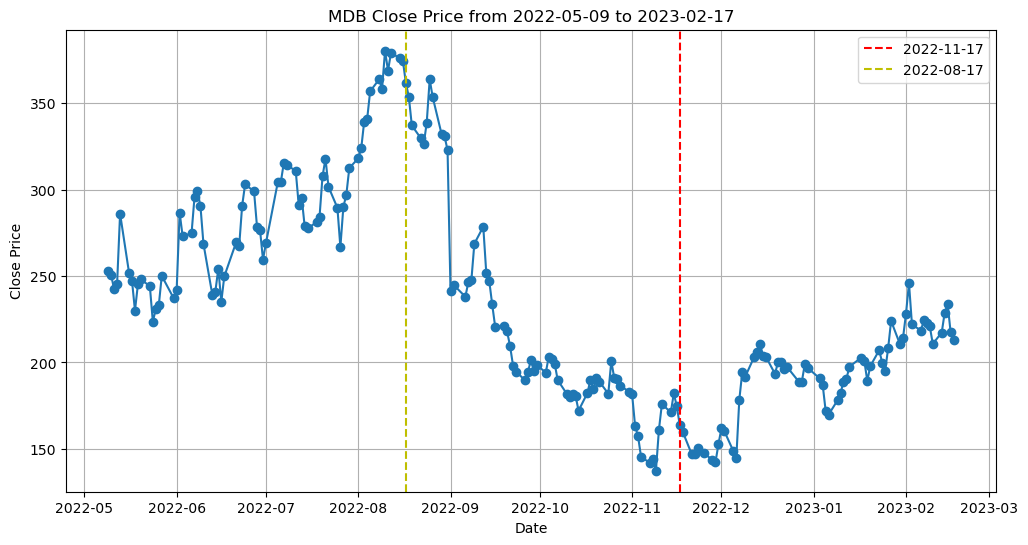

In [25]:
companyplot = 'MDB'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

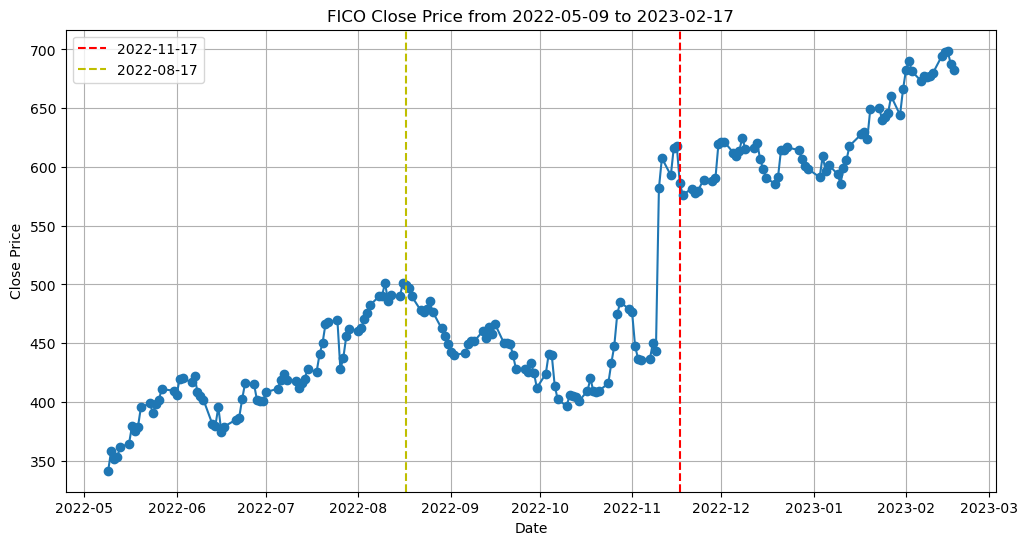

In [26]:
companyplot = 'FICO'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

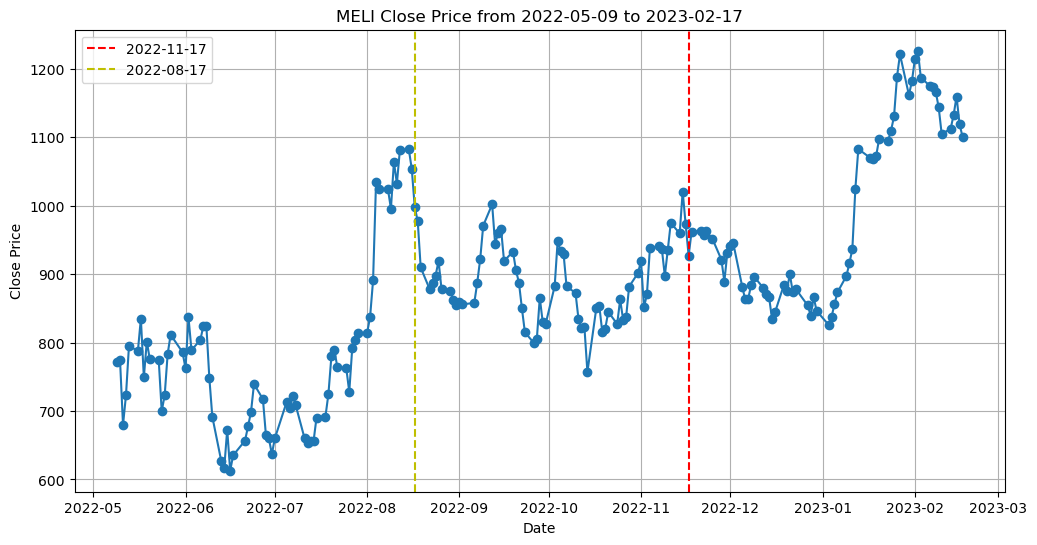

In [27]:
companyplot = 'MELI'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()

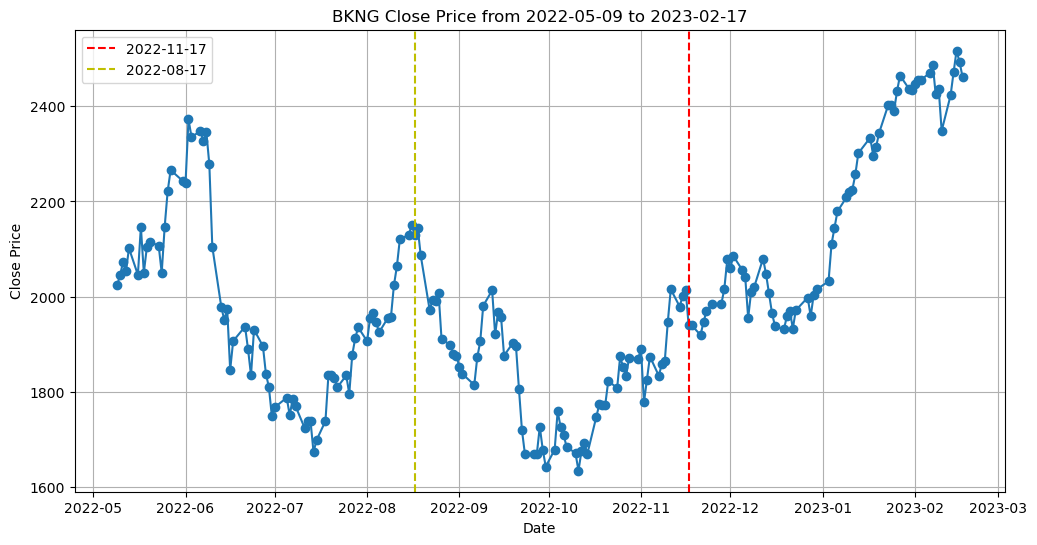

In [28]:
companyplot = 'BKNG'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-05-09').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2023-02-17').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-05-09 to 2023-02-17')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-11-17'), color='r', linestyle='--', label='2022-11-17')
plt.axvline(pd.to_datetime('2022-08-17'), color='y', linestyle='--', label='2022-08-17')
plt.legend()

plt.show()